In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,img_to_array,array_to_img
import PIL
import PIL.Image
import tensorflow as tf
from glob import glob
import pathlib
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import sys
import cv2 
import os
import time
import warnings
warnings.filterwarnings("ignore")

In [21]:
training_path = r'C:\Users\Chaitanya\Documents\ML\project\Brain-tumor-MRI\Training'
testing_path = r'C:\Users\Chaitanya\Documents\ML\project\Brain-tumor-MRI\Testing'

In [32]:
training_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    validation_split = 0.2,
    seed = 48,
    subset='training',
    label_mode='categorical',
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [33]:
validation_data = tf.keras.utils.image_dataset_from_directory(
    training_path,
    validation_split = 0.2,
    seed = 48,
    subset='validation',
    label_mode='categorical',
)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [34]:
test_data = tf.keras.utils.image_dataset_from_directory(
    testing_path,
    seed = 48,
    label_mode='categorical',

)

Found 1311 files belonging to 4 classes.


In [26]:
training_data.class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

#### InceptionResnvet V2

In [8]:
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, 
    weights = 'imagenet',
    input_shape = (256, 256, 3) )

In [9]:
base_model.trainable = False

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
    tf.keras.layers.RandomContrast(factor = 0.1)]
)

In [11]:
prediction_layer = tf.keras.layers.Dense(4, activation = "softmax")

In [12]:
inputs = tf.keras.Input((256, 256, 3))
x = data_augmentation(inputs)

x = tf.keras.applications.inception_resnet_v2.preprocess_input(x)
x = base_model(x, training = False)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = prediction_layer(x)

In [13]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                             

In [14]:
model.compile(
  loss=tf.keras.losses.CategoricalCrossentropy(),
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
  metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
  )


In [15]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, mode='auto', restore_best_weights=True)

In [15]:
model_history = model.fit(training_data, validation_data = validation_data, batch_size = 8, epochs = 20)

Epoch 1/20
143/143 [==============================] - 349s 2s/step - loss: 0.5663 - accuracy: 0.7821 - precision: 0.8349 - recall: 0.7249 - val_loss: 0.5116 - val_accuracy: 0.8012 - val_precision: 0.8316 - val_recall: 0.7828
Epoch 2/20
143/143 [==============================] - 293s 2s/step - loss: 0.4045 - accuracy: 0.8514 - precision: 0.8840 - recall: 0.8153 - val_loss: 0.3333 - val_accuracy: 0.8765 - val_precision: 0.9077 - val_recall: 0.8441
Epoch 3/20
143/143 [==============================] - 292s 2s/step - loss: 0.3643 - accuracy: 0.8705 - precision: 0.8927 - recall: 0.8379 - val_loss: 0.2629 - val_accuracy: 0.9081 - val_precision: 0.9263 - val_recall: 0.8914
Epoch 4/20
143/143 [==============================] - 291s 2s/step - loss: 0.3312 - accuracy: 0.8814 - precision: 0.9066 - recall: 0.8556 - val_loss: 0.2835 - val_accuracy: 0.8932 - val_precision: 0.9101 - val_recall: 0.8687
Epoch 5/20
143/143 [==============================] - 291s 2s/step - loss: 0.2918 - accuracy: 0.8952

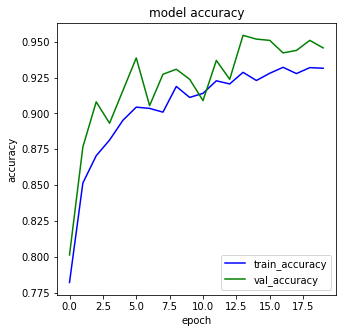

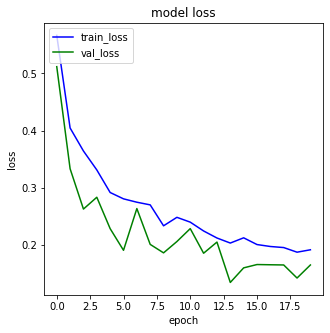

In [16]:
plt.figure(figsize=(5,5))
# summarize history for accuracy
hist=model_history.history
plt.plot(hist["accuracy"],color="b",label="train_accuracy")
plt.plot(hist["val_accuracy"],color="g",label="val_accuracy")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(5,5))
# summarize history for loss
plt.plot(hist['loss'],color="b",label="train_loss")
plt.plot(hist['val_loss'],color="g",label="val_loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper left')
plt.show()

In [17]:
training_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [18]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [18]:
model.evaluate(test_data)

41/41 [==============================] - 13s 299ms/step - loss: 0.2445 - accuracy: 0.9108 - precision: 0.9168 - recall: 0.9077


[0.2444831132888794,
 0.9107551574707031,
 0.9167950749397278,
 0.9077040553092957]

In [39]:
inceptionResnet_results = {"Training":[0.931,0.938,0.923],
            "Validation":[0.945,0.949,0.942],
            "Testing":[0.910,0.916,0.9077]}
inceptionresnet_model = pd.DataFrame(inceptionResnet_results,index= pd.Index(["Accuracy","Precision","Recall"]))

In [40]:
inceptionresnet_model

,Training,Validation,Testing
Accuracy,0.931,0.945,0.9100
Precision,0.938,0.949,0.9160
Recall,0.923,0.942,0.9077


#### CNN

In [1]:
import tensorflow as tf
import cv2
import keras
import matplotlib.pyplot as plt
import os 
import glob as gb 
import pandas as pd 
import numpy as np
import random
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
training_path = r'C:\Users\Chaitanya\Documents\ML\project\Brain-tumor-MRI\Training'
testing_path = r'C:\Users\Chaitanya\Documents\ML\project\Brain-tumor-MRI\Testing'


In [3]:
v=0
for folder in os.listdir(training_path):
    files=gb.glob(pathname=str(training_path+"//"+folder+"/*.jpg"))
    x= len(files)
    v=v+x
    print(f"the training images in folder {folder} is {len(files)} ")
print(f"the total images is {v}")

the training images in folder glioma is 1321 
the training images in folder meningioma is 1339 
the training images in folder notumor is 1595 
the training images in folder pituitary is 1457 
the total images is 5712


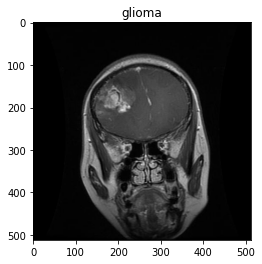

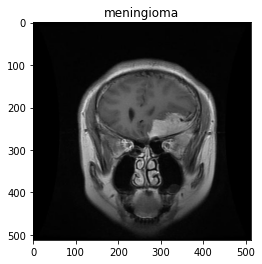

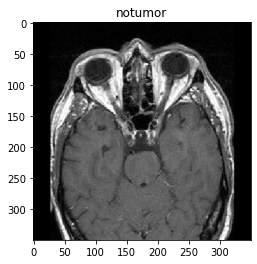

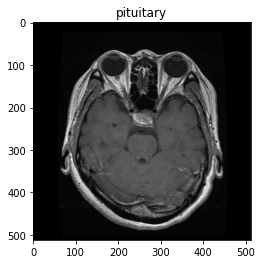

The size of training set is 5712 
(512, 512)    3955
(225, 225)     268
(630, 630)      77
(236, 236)      53
(251, 201)      43
              ... 
(236, 255)       1
(218, 233)       1
(401, 312)       1
(369, 503)       1
(741, 900)       1
Length: 382, dtype: int64


In [4]:
train_size=[]
for folder in os.listdir(training_path):
    x=0
    files=gb.glob(pathname=str(training_path+"//"+folder+"/*.jpg"))
    for file in files:
        img=cv2.imread(file,cv2.IMREAD_GRAYSCALE)
        train_size.append(img.shape)
        x=x+1
        if x<=1:
            plt.imshow(img, cmap='gray')
            plt.title(folder)
            plt.show()
            
print(f"The size of training set is {len(train_size)} ")
print(pd.Series(train_size).value_counts())

In [5]:
v=0
for folder in os.listdir(testing_path):
    files=gb.glob(pathname=str(testing_path+"//"+folder+"/*.jpg"))
    x= len(files)
    v=v+x
    print(f"the testing images in folder {folder} is {len(files)} ")
print(f"the total images is {v}")

the testing images in folder glioma is 300 
the testing images in folder meningioma is 306 
the testing images in folder notumor is 405 
the testing images in folder pituitary is 300 
the total images is 1311


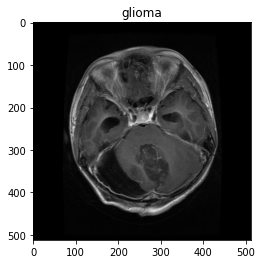

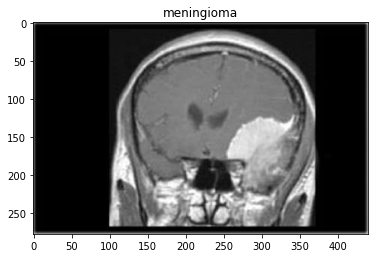

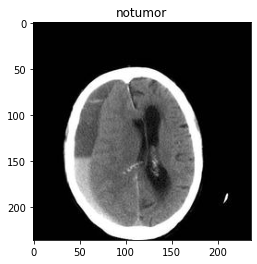

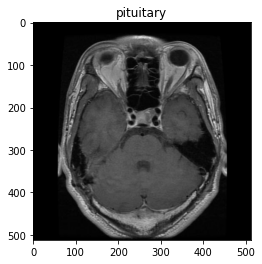

The size of testing set is 1311 
(512, 512)    787
(225, 225)     64
(236, 236)     28
(222, 227)     17
(251, 201)     15
             ... 
(248, 239)      1
(354, 289)      1
(337, 305)      1
(410, 304)      1
(474, 356)      1
Length: 194, dtype: int64


In [6]:
test_size=[]
for folder in os.listdir(testing_path):
    x=0
    files=gb.glob(pathname=str(testing_path+"//"+folder+"/*.jpg"))
    for file in files:
        img=cv2.imread(file,cv2.IMREAD_GRAYSCALE)
        test_size.append(img.shape)
        x=x+1
        if x<=1:
            plt.imshow(img, cmap='gray')
            plt.title(folder)
            plt.show()

print(f"The size of testing set is {len(test_size)} ")
print(pd.Series(test_size).value_counts())

In [54]:
training_data1 = tf.keras.utils.image_dataset_from_directory(
    training_path,
    validation_split = 0.2,
    seed = 48,
    subset='training',
    batch_size = 8,
    image_size=(256, 256),
    shuffle=True,
    label_mode='categorical',
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [55]:
validation_data1 = tf.keras.utils.image_dataset_from_directory(
    training_path,
    validation_split = 0.2,
    seed = 48,
    batch_size = 8,
    image_size=(256, 256),
    shuffle=True,
    subset='validation',
    label_mode='categorical',
)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [56]:
testing_data1 = tf.keras.utils.image_dataset_from_directory(
    testing_path,
    seed = 48,
    batch_size = 8,
    image_size = (256, 256),
    shuffle = True,
    label_mode = "categorical",
)

Found 1311 files belonging to 4 classes.


In [57]:
filter_size=(5,5)
model1=keras.models.Sequential([
    
    keras.layers.Conv2D(32,kernel_size=filter_size,activation='relu',input_shape=(256,256,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(.2),
    
    keras.layers.Conv2D(64,kernel_size=filter_size,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(.2),
    
    keras.layers.Conv2D(128,kernel_size=filter_size,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(.2),

    keras.layers.Conv2D(128,kernel_size=filter_size,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(.2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(.2),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(.2),
    
    keras.layers.Dense(4,activation='softmax')
])  

In [58]:
from tensorflow.keras.optimizers import *

In [59]:
model1.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

In [60]:
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 252, 252, 32)      2432      
                                                                 
 batch_normalization_16 (Bat  (None, 252, 252, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 126, 126, 32)     0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 126, 126, 32)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 122, 122, 64)      51264     
                                                                 
 batch_normalization_17 (Bat  (None, 122, 122, 64)    

In [61]:
history1 = model1.fit(training_data1, 
          epochs=15,
          validation_data=validation_data1
         )

Epoch 1/15
572/572 [==============================] - 42s 70ms/step - loss: 0.8980 - accuracy: 0.7155 - precision_6: 0.7338 - recall_6: 0.6932 - val_loss: 0.6737 - val_accuracy: 0.7356 - val_precision_6: 0.7569 - val_recall_6: 0.7198
Epoch 2/15
572/572 [==============================] - 40s 70ms/step - loss: 0.5757 - accuracy: 0.7961 - precision_6: 0.8113 - recall_6: 0.7810 - val_loss: 0.3872 - val_accuracy: 0.8695 - val_precision_6: 0.8783 - val_recall_6: 0.8529
Epoch 3/15
572/572 [==============================] - 41s 72ms/step - loss: 0.4303 - accuracy: 0.8495 - precision_6: 0.8582 - recall_6: 0.8370 - val_loss: 0.5669 - val_accuracy: 0.8301 - val_precision_6: 0.8411 - val_recall_6: 0.8249
Epoch 4/15
572/572 [==============================] - 41s 72ms/step - loss: 0.3198 - accuracy: 0.8860 - precision_6: 0.8944 - recall_6: 0.8783 - val_loss: 0.2567 - val_accuracy: 0.9203 - val_precision_6: 0.9279 - val_recall_6: 0.9133
Epoch 5/15
572/572 [==============================] - 116s 204ms

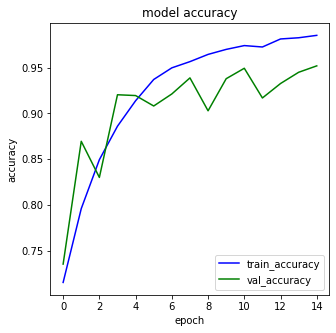

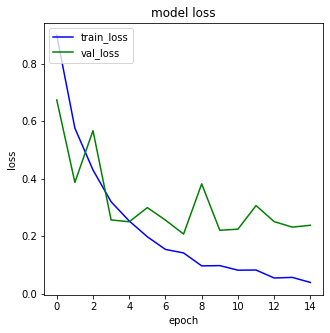

In [63]:
plt.figure(figsize=(5,5))
# summarize history for accuracy
hist2=history1.history
plt.plot(hist2["accuracy"],color="b",label="train_accuracy")
plt.plot(hist2["val_accuracy"],color="g",label="val_accuracy")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(5,5))
# summarize history for loss
plt.plot(hist2['loss'],color="b",label="train_loss")
plt.plot(hist2['val_loss'],color="g",label="val_loss")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper left')
plt.show()

In [64]:
model1.evaluate(validation_data1)

143/143 [==============================] - 13s 85ms/step - loss: 0.2382 - accuracy: 0.9518 - precision_6: 0.9518 - recall_6: 0.9518


[0.23816180229187012,
 0.9518388509750366,
 0.9518388509750366,
 0.9518388509750366]

In [66]:
model1.evaluate(testing_data1)

164/164 [==============================] - 3s 18ms/step - loss: 0.2039 - accuracy: 0.9565 - precision_6: 0.9565 - recall_6: 0.9565


[0.2039126306772232, 0.95652174949646, 0.95652174949646, 0.95652174949646]

In [67]:
cnn_results = {"Training":[0.985,0.985,0.985],
            "Validation":[0.951,0.951,0.951],
            "Testing":[0.956,0.956,0.956]}
cnn_model = pd.DataFrame(cnn_results,index= pd.Index(["Accuracy","Precision","Recall"]))

In [68]:
cnn_model

,Training,Validation,Testing
Accuracy,0.985,0.951,0.956
Precision,0.985,0.951,0.956
Recall,0.985,0.951,0.956


In [71]:
overall_results = {"Accuracy":[0.956,0.910,0.907,0.960,0.952,0.919],
                    "Precision":[0.956,0.916,0.925,0.96,0.952,0.927],
                    "Recacll":[0.956,0.907,0.894,0.96,0.952,0.910]}
final_test_results = pd.DataFrame(overall_results,index= pd.Index(["CNN","InceptionResnet V2","Inception V3","ResNet50","VGG16","Xception"]))

In [72]:
final_test_results

,Accuracy,Precision,Recacll
CNN,0.956,0.956,0.956
InceptionResnet V2,0.910,0.916,0.907
Inception V3,0.907,0.925,0.894
ResNet50,0.960,0.960,0.960
VGG16,0.952,0.952,0.952
Xception,0.919,0.927,0.910
